# R vs Python: head to head data analysis - R 

## Read in a csv file

In [1]:
nba <- read.csv("nba_2013.csv")

## Find the number of players

In [2]:
dim(nba)

[1] 481  31

## Look at the first two row of the data

In [3]:
head(nba, 2)

,player,pos,age,bref_team_id,g,gs,mp,fg,fga,fg.,ellip.h,drb,trb,ast,stl,blk,tov,pf,pts,season,season_end
1,Quincy Acy,SF,23,TOT,63,0,847,66,141,0.468,⋯,144,216,28,23,26,30,122,171,2013-2014,2013
2,Steven Adams,C,20,OKC,81,20,1197,93,185,0.503,⋯,190,332,43,40,57,71,203,265,2013-2014,2013


## Find the average of each statistic

In [4]:
sapply(nba, mean, na.rm=TRUE)

Warning message:
In mean.default(X[[i]], ...): argument is not numeric or logical: returning NAWarning message:
In mean.default(X[[i]], ...): argument is not numeric or logical: returning NAWarning message:
In mean.default(X[[i]], ...): argument is not numeric or logical: returning NAWarning message:
In mean.default(X[[i]], ...): argument is not numeric or logical: returning NA

player          pos          age bref_team_id            g           gs 
          NA           NA   26.5093555           NA   53.2536383   25.5717256 
          mp           fg          fga          fg.          x3p         x3pa 
1237.3866944  192.8814969  424.4636175    0.4364363   39.6133056  110.1309771 
        x3p.          x2p         x2pa         x2p.         efg.           ft 
   0.2851112  153.2681913  314.3326403    0.4669472    0.4807516   91.2058212 
         fta          ft.          orb          drb          trb          ast 
 120.6424116    0.7224187   55.8108108  162.8170478  218.6278586  112.5363825 
         stl          blk          tov           pf          pts       season 
  39.2806653   24.1039501   71.8627859  105.8690229  516.5821206           NA 
  season_end 
2013.0000000

## Make pairwise scatterplots

In [6]:
library(ggplot2)
ggpairs(nba[,c("ast", "fg", "trb")])

ERROR: Error in eval(expr, envir, enclos): could not find function "ggpairs"


## Make clusters of the players
One good way to explore this kind of data is to generate cluster plots. These will show which players are most similar.

In [7]:
library(cluster)
set.seed(1)
isGoodCol <- function(col){
   sum(is.na(col)) == 0 && is.numeric(col) 
}
goodCols <- sapply(nba, isGoodCol)
clusters <- kmeans(nba[,goodCols], centers=5)
labels <- clusters$cluster

## Plot players by cluster

ERROR: Error in file(con, "rb"): cannot open the connection


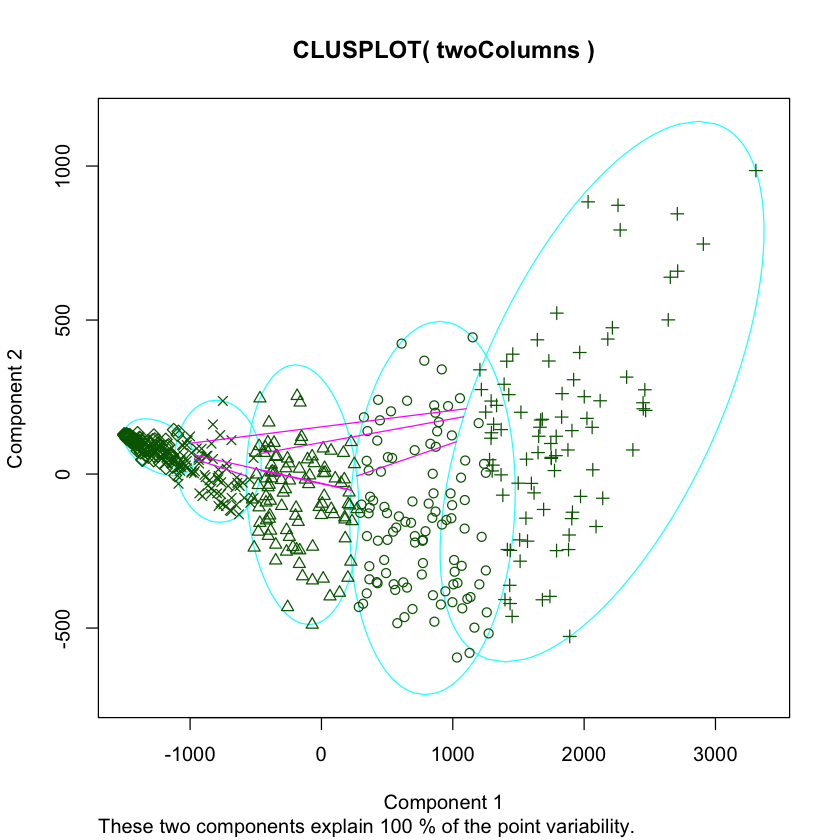

In [8]:
nba2d <- prcomp(nba[,goodCols], center=TRUE)
twoColumns <- nba2d$x[,1:2]
clusplot(twoColumns, labels)

## Split into training and testing sets

In [7]:
trainRowCount <- floor(0.8 * nrow(nba))
set.seed(1)
trainIndex <- sample(1:nrow(nba), trainRowCount)
train <- nba[trainIndex,]
test <- nba[-trainIndex,]

## Univariate linear regression

In [8]:
fit <- lm(ast ~ fg, data=train)
predictions <- predict(fit, test)

## Calculate summary statistics for the model

In [9]:
summary(fit)


Call:
lm(formula = ast ~ fg, data = train)

Residuals:
    Min      1Q  Median      3Q     Max 
-228.26  -35.38  -11.45   11.99  559.61 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   9.0585     7.1026   1.275    0.203    
fg            0.5307     0.0274  19.368   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 92.89 on 382 degrees of freedom
Multiple R-squared:  0.4954,	Adjusted R-squared:  0.4941 
F-statistic: 375.1 on 1 and 382 DF,  p-value: < 2.2e-16


## Fit a random forest model

In [11]:
library(randomForest)
predictorColumns <- c("age", "mp", "fg", "trb", "stl", "blk")
rf <- randomForest(train[predictorColumns], train$ast, ntree=100)
predictions <- predict(rf, test[predictorColumns])

## Calculate error

In [12]:
mean((test["ast"] - predictions)^2)

[1] 4774.05

# Download a webpage

In [14]:
library(RCurl)
url <- "http://www.basketball-reference.com/boxscores/201506140GSW.html"
data <- readLines(url)

## Extract player box scores

In [18]:
library(rvest)
page <- read_html(url)
table <- html_nodes(page, ".stats_table")[3]
rows <- html_nodes(table, "tr")
cells <- html_nodes(rows, "td a")
teams <- html_text(cells)

extractRow <- function(rows, i){
    if(i == 1){
        return
    }
    row <- rows[i]
    tag <- "td"
    if(i == 2){
        tag <- "th"
    }
    items <- html_nodes(row, tag)
    html_text(items)
}

scrapeData <- function(team){
    teamData <- html_nodes(page, paste("#",team,"_basic", sep=""))
    rows <- html_nodes(teamData, "tr")
    lapply(seq_along(rows), extractRow, rows=rows) 
}

data <- lapply(teams, scrapeData)

[[1]]
[[1]][[1]]
character(0)

[[1]][[2]]
 [1] "Starters" "MP"       "FG"       "FGA"      "FG%"      "3P"      
 [7] "3PA"      "3P%"      "FT"       "FTA"      "FT%"      "ORB"     
[13] "DRB"      "TRB"      "AST"      "STL"      "BLK"      "TOV"     
[19] "PF"       "PTS"      "+/-"     

[[1]][[3]]
 [1] "LeBron James" "44:46"        "15"           "34"           ".441"        
 [6] "3"            "8"            ".375"         "7"            "9"           
[11] ".778"         "1"            "13"           "14"           "11"          
[16] "1"            "0"            "2"            "5"            "40"          
[21] "-11"         

[[1]][[4]]
 [1] "Matthew Dellavedova" "41:41"               "2"                  
 [4] "9"                   ".222"                "1"                  
 [7] "5"                   ".200"                "0"                  
[10] "0"                   ""                    "0"                  
[13] "0"                   "0"                   "2"                  
[16] "3"                   "0"                   "2"                  
[19] "4"                   "5"                   "-19"                

[[1]][[5]]
 [1] "Tristan Thompson" "39:49"            "6"                "11"              
 [5] ".545"             "0"                "0"                ""                
 [9] "7"                "10"               ".700"             "5"               
[13] "5"                "10"               "0"                "2"               
[17] "2"                "1"                "4"                "19"              
[21] "-22"             

[[1]][[6]]
 [1] "Iman Shumpert" "37:18"         "3"             "9"            
 [5] ".333"          "3"             "6"             ".500"         
 [9] "1"             "2"             ".500"          "3"            
[13] "2"             "5"             "2"             "1"            
[17] "0"             "1"             "4"             "10"           
[21] "-10"          

[[1]][[7]]
 [1] "Timofey Mozgov" "9:19"           "0"              "1"             
 [5] ".000"           "0"              "0"              ""              
 [9] "0"              "0"              ""               "0"             
[13] "0"              "0"              "0"              "1"             
[17] "0"              "2"              "2"              "0"             
[21] "-4"            

[[1]][[8]]
character(0)

[[1]][[9]]
 [1] "J.R. Smith" "35:42"      "5"          "15"         ".333"      
 [6] "4"          "14"         ".286"       "0"          "0"         
[11] ""           "1"          "6"          "7"          "2"         
[16] "1"          "2"          "1"          "3"          "14"        
[21] "-6"        

[[1]][[10]]
 [1] "James Jones" "17:47"       "0"           "1"           ".000"       
 [6] "0"           "1"           ".000"        "0"           "0"          
[11] ""            "0"           "1"           "1"           "0"          
[16] "1"           "0"           "0"           "4"           "0"          
[21] "+1"         

[[1]][[11]]
 [1] "Mike Miller" "13:38"       "1"           "1"           "1.000"      
 [6] "1"           "1"           "1.000"       "0"           "0"          
[11] ""            "0"           "0"           "0"           "0"          
[16] "0"           "0"           "1"           "2"           "3"          
[21] "+6"         

[[1]][[12]]
[1] "Joe Harris"   "Did Not Play"

[[1]][[13]]
[1] "Kyrie Irving" "Did Not Play"

[[1]][[14]]
[1] "Brendan Haywood" "Did Not Play"   

[[1]][[15]]
[1] "Shawn Marion" "Did Not Play"

[[1]][[16]]
[1] "Kendrick Perkins" "Did Not Play"    

[[1]][[17]]
 [1] "Team Totals" "240"         "32"          "81"          ".395"       
 [6] "12"          "35"          ".343"        "15"          "21"         
[11] ".714"        "10"          "27"          "37"          "17"         
[16] "10"          "4"           "10"          "28"          "91"         
[21] ""           


[[2]]
[[2]][[1]]
character(0)

[[2]][[2]]
 [1]